#Setup and Imports

In [49]:
import pickle
from google.colab import drive
import seaborn as sns
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import glob
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
!pip install umap-learn
import umap.umap_ as umap
import pandas as pd
!pip install hdbscan
import hdbscan
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity


drive.mount('/content/drive', force_remount=True)

os.chdir('/content/drive/MyDrive/cs224w_project')

Mounted at /content/drive


In [2]:
def create_merged_dataset_hetero(path, topic, decade):
  '''helper function that merges the node embeddings with ground truth data'''
  hetero_embeds = torch.load(path, weights_only=True)
  hetero_embeds = hetero_embeds['newspaper']
  ground_truths = pd.read_pickle(f"karsen_redo/DATA/clean_ground_truths.pkl")
  newspaper_indices = pd.read_pickle(f"karsen_redo/HETEROGNN/newspaper_node_index-{decade}-{decade+10}-{topic}.pkl")
# Convert tensor to DataFrame
  embeds_array = hetero_embeds.numpy() if isinstance(hetero_embeds, torch.Tensor) else hetero_embeds

  # Create a DataFrame for embeddings
  embeds_df = pd.DataFrame(embeds_array)
  embeds_df = embeds_df.rename_axis('index').reset_index()

  # Convert newspaper_indices to a DataFrame
  indices_df = pd.DataFrame(list(newspaper_indices.items()), columns=['outlet_name', 'index'])
  merged_indices_embeds = pd.merge(indices_df, embeds_df, on='index')
  merged_indices_embeds['outlet_name'] = merged_indices_embeds['outlet_name'].astype(str)
  #merged_indices_embeds['outlet_name'] = merged_indices_embeds['outlet_name'].str.extract(r"\('(.+?)',\)")

  # Merge with ground_truths on outlet_name to get the label
  final_dataset = pd.merge(merged_indices_embeds, ground_truths, on='outlet_name')
  return final_dataset

#Compare Embeddings Across Topics

We choose the heterogeneous GNN with best AUC-ROC: ```Heterogeneous SAGEConv with {'alpha':10, 'lr':0.005, 'hidden size':128, 'output size':128, 'layers':1, 'temperature':0.08}``` and compare node embeddings with various methods


In [31]:
def create_embedding_plot(topic, decade, model, model_name, graph_type='hetero', reduction_method='TSNE', title='Embedding', use_colors=True, sample_fraction=0.2):
    """
    Generates a 3D scatter plot of dimension-reduced raw node features, color-coded by label (Republican/Red or Democrat/Blue).

    Parameters:
    - topic (str): Topic of interest (e.g., 'labor', 'economics').
    - decade (int): Decade of interest (e.g., 60, 70, 80).
    - reduction_method (str): Dimensionality reduction method ('TSNE', 'PCA', 'UMAP'). Default is 'TSNE'.
    - use_colors (bool): Whether to color points by label. Default is True.

    Returns:
    - Saves and displays a 3D scatter plot with the reduced features.

    Notes:
    - Uses StandardScaler for feature scaling before dimensionality reduction.
    - Colors points based on labels: red for Republican (0), blue for Democrat (1).
    """
    # Helper function for dimensionality reduction with sampling
    def reduce_dimensions_with_sampling(X, method, sample_fraction, **kwargs):
        sample_size = int(len(X) * sample_fraction)
        sampled_indices = np.random.choice(len(X), size=sample_size, replace=False)
        X_sample = X[sampled_indices]

        if method.upper() == 'TSNE':
            reducer = TSNE(n_components=3, random_state=2, **kwargs)
        elif method.upper() == 'PCA':
            reducer = PCA(n_components=3, random_state=2)
        elif method.upper() == 'UMAP':
            reducer = umap.UMAP(n_components=3, random_state=2, **kwargs)
        else:
            raise ValueError(f"Unsupported reduction method: {method}. Choose from 'PCA', 'TSNE', or 'UMAP'.")

        # Fit on sampled data and transform the full dataset
        reducer.fit(X_sample)
        return reducer.fit_transform(X)

    # Define path and load dataset
    path = f'karsen_redo/{graph_type.upper()}GNN/{topic}_{decade}{decade+10}/{model}.pt'
    if graph_type == 'hetero':
        df = create_merged_dataset_hetero(path, topic, decade)

    # Isolate newspaper node embeddings
    X = df.iloc[:, 2:-1].to_numpy()

    # Define parameters for dimensionality reduction
    reduction_params = {}
    if reduction_method.upper() == 'TSNE':
        reduction_params['perplexity'] = int(df.shape[0] * 0.05)  # Set perplexity to around 5% of dataset

    # Perform dimensionality reduction with sampling
    X_embedded = reduce_dimensions_with_sampling(X, reduction_method, sample_fraction=sample_fraction, **reduction_params)

    # Combine results
    reduced_result = pd.concat([
        df.reset_index()['label'],
        pd.DataFrame(X_embedded, columns=[f'{reduction_method.lower()}1', f'{reduction_method.lower()}2', f'{reduction_method.lower()}3'])
    ], axis=1)

    # Define labels and colors
    labels = reduced_result['label']
    colors_list = ['red' if label == 0 else 'blue' for label in labels]

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 8))  # Adjust figure size for better visibility
    ax = fig.add_subplot(111, projection='3d')

    if use_colors:
        scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=colors_list, s=40, alpha=0.8)

        # Add a legend
        legend_labels = ['Republican (Red)', 'Democrat (Blue)']
        legend_colors = ['red', 'blue']
        for label, color in zip(legend_labels, legend_colors):
            ax.scatter([], [], c=color, label=label)  # Dummy scatter points for legend

        ax.legend(loc='upper right', fontsize=10)  # Add legend to the plot
    else:
        scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], s=40, alpha=0.8)

    # Set axis labels and title
    ax.set_xlabel('X Label', fontsize=12, labelpad=10)
    ax.set_ylabel('Y Label', fontsize=12, labelpad=10)
    ax.set_zlabel('Z Label', fontsize=12, labelpad=10)
    ax.set_title(f"{model_name.title()} {title} for 19{decade}s {topic.title()} Topic ({reduction_method.upper()})", fontsize=15, pad=20)

    # Save the plot
    output_folder = 'Writeup/'
    os.makedirs(output_folder, exist_ok=True)  # Create directory if it doesn't exist
    file_path = os.path.join(output_folder, f'{topic}_{decade}_{model}_{graph_type}_{reduction_method.lower()}.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

    print(f'Graph saved at: {file_path}')


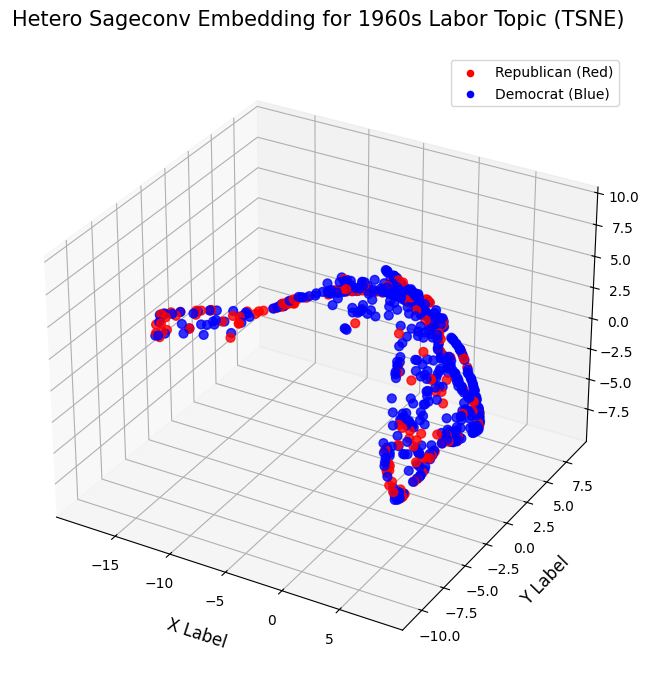

Graph saved at: Writeup/labor_60_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_tsne.png


In [32]:
create_embedding_plot(topic='labor',
                      decade=60,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='tsne')

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


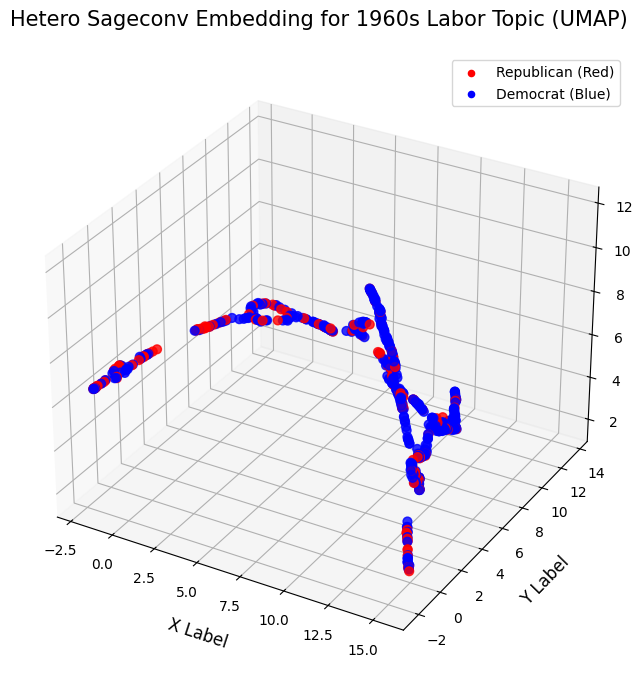

Graph saved at: Writeup/labor_60_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_umap.png


In [33]:
create_embedding_plot(topic='labor',
                      decade=60,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='umap')

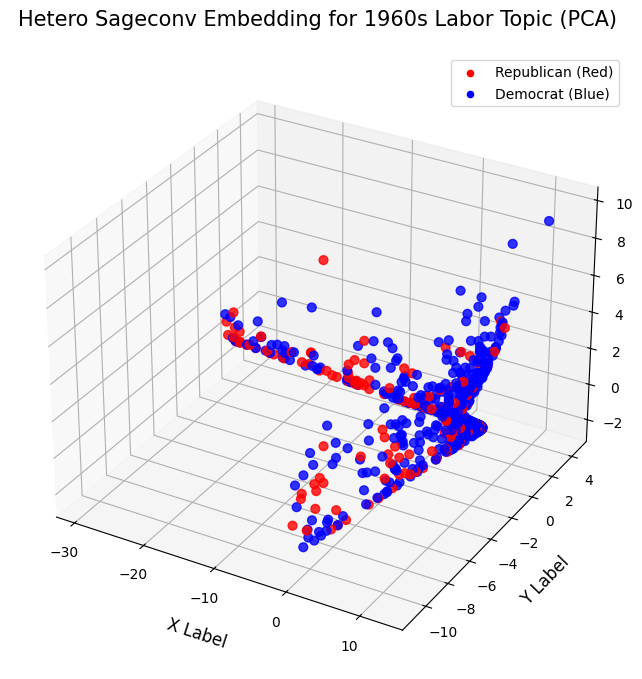

Graph saved at: Writeup/labor_60_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_pca.png


In [34]:
create_embedding_plot(topic='labor',
                      decade=60,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='pca')

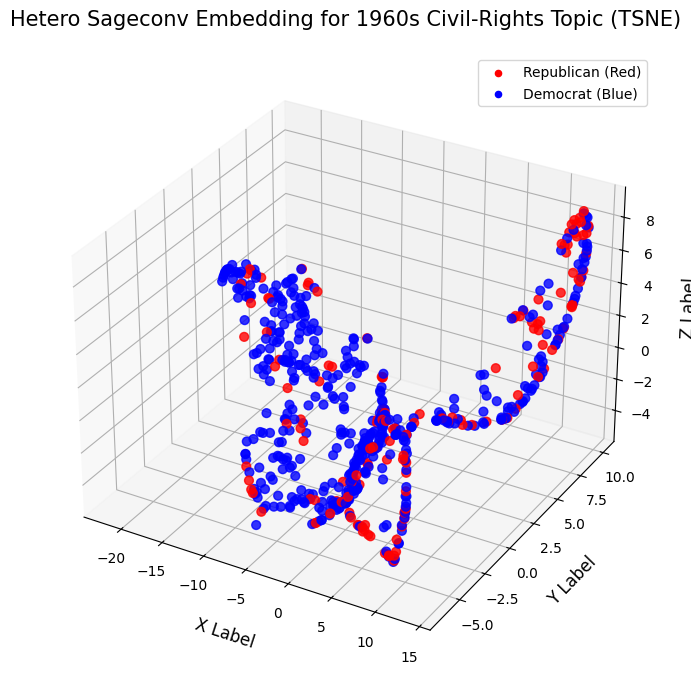

Graph saved at: Writeup/civil-rights_60_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_tsne.png


In [35]:
create_embedding_plot(topic='civil-rights',
                      decade=60,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='tsne')

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


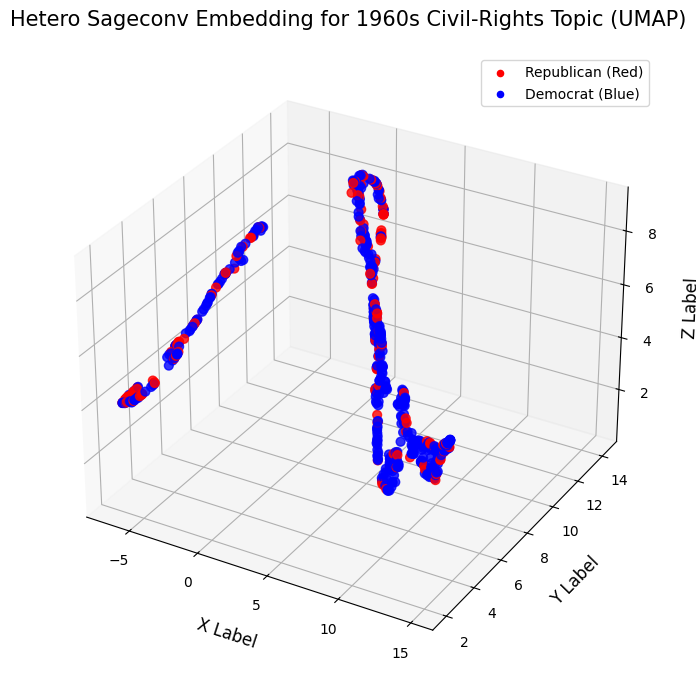

Graph saved at: Writeup/civil-rights_60_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_umap.png


In [36]:
create_embedding_plot(topic='civil-rights',
                      decade=60,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='umap')

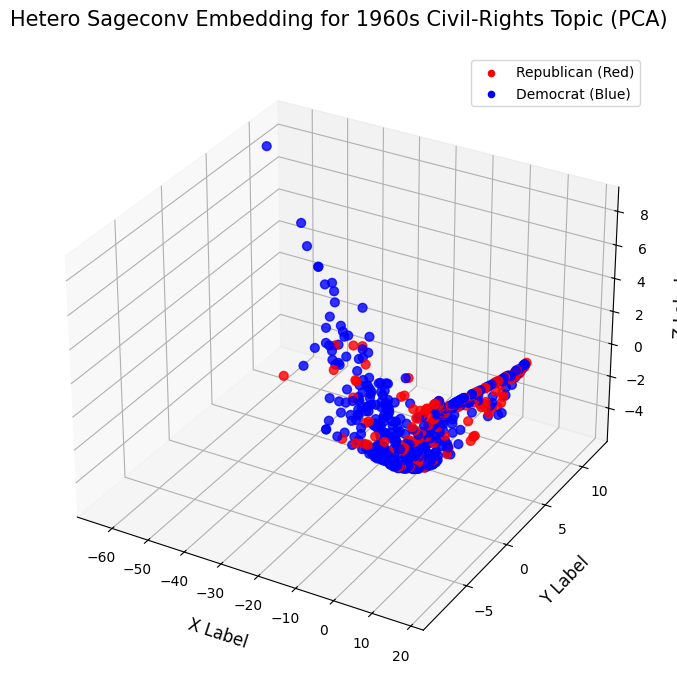

Graph saved at: Writeup/civil-rights_60_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_pca.png


In [37]:
create_embedding_plot(topic='civil-rights',
                      decade=60,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='pca')

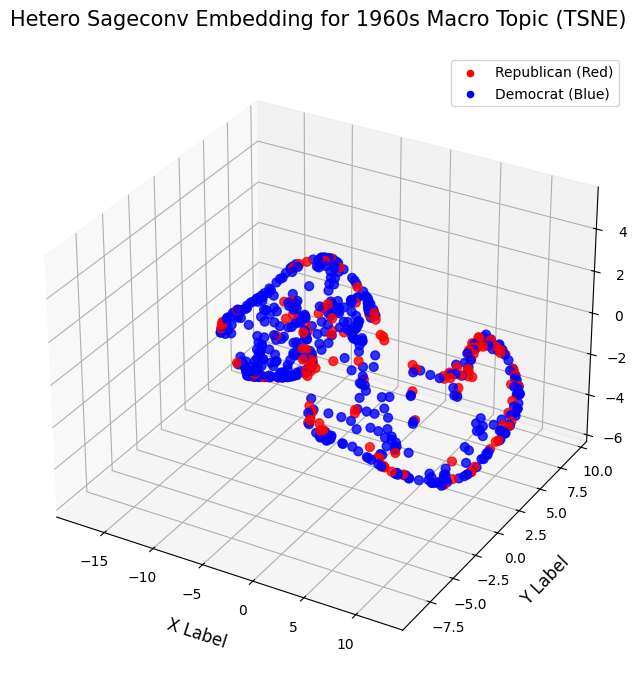

Graph saved at: Writeup/macro_60_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_tsne.png


In [38]:
create_embedding_plot(topic='macro',
                      decade=60,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='tsne')

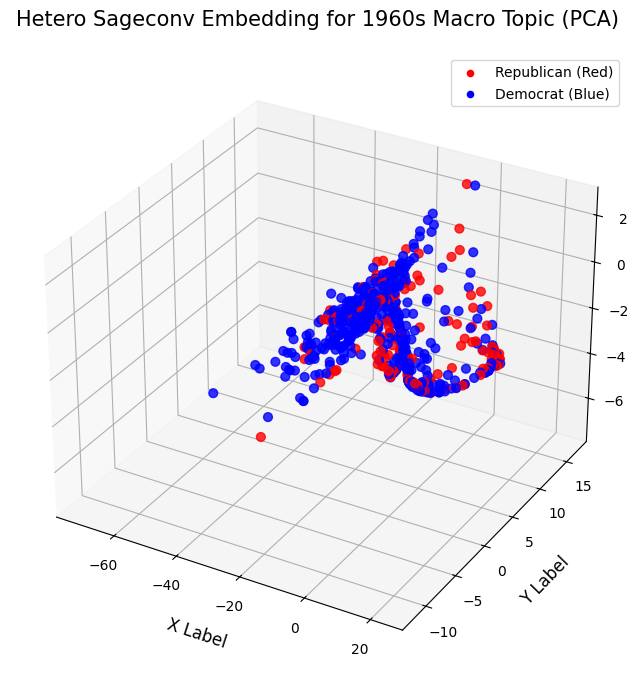

Graph saved at: Writeup/macro_60_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_pca.png


In [39]:
create_embedding_plot(topic='macro',
                      decade=60,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='pca')

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


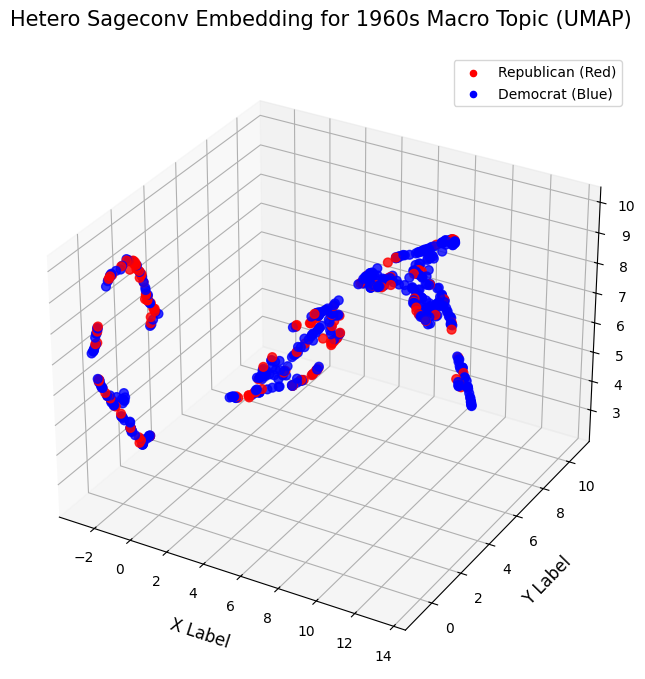

Graph saved at: Writeup/macro_60_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_umap.png


In [40]:
create_embedding_plot(topic='macro',
                      decade=60,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='umap')

# HDBSCAN Clustering for Political Understanding

We cluster the newspaper embeddings to see what patterns arise

In [19]:
def compute_mean_radius(topic, decade, model, model_name, graph_type='hetero'):
    """
    Computes the mean and maximum Euclidean distance from the centroid of node embeddings.

    Parameters:
    - topic (str): Topic of interest (e.g., 'labor', 'economics').
    - decade (int): Decade of interest (e.g., 60, 70, 80).
    - model (str): Model name or identifier.
    - model_name (str): Display name for the model.
    - graph_type (str): Type of graph ('hetero'). Default is 'hetero'.

    Returns:
    - mean_radius (float): Mean Euclidean distance of node embeddings to the centroid.
    - max_radius (float): Maximum Euclidean distance of node embeddings to the centroid.
    """
    path = f'karsen_redo/{graph_type.upper()}GNN/{topic}_{decade}{decade+10}/{model}.pt'
    if graph_type == 'hetero':
        df = create_merged_dataset_hetero(path, topic, decade)
    embeddings = df.iloc[:, 2:-1].to_numpy()
    # Compute centroid
    centroid = np.mean(embeddings, axis=0)

    # Compute Euclidean distance of each point to the centroid
    distances = np.linalg.norm(embeddings - centroid, axis=1)

    # Return the mean distance (radius)
    return np.mean(distances), np.max(distances)

def create_cluster_df(topic, decade, model, model_name, graph_type='hetero'):
    """
    Creates a dataframe with node embeddings and HDBSCAN clustering results based on cosine distance.

    Parameters:
    - topic (str): Topic of interest (e.g., 'labor', 'economics').
    - decade (int): Decade of interest (e.g., 60, 70, 80).
    - model (str): Model name or identifier.
    - model_name (str): Display name for the model.
    - graph_type (str): Type of graph ('hetero'). Default is 'hetero'.

    Returns:
    - df (DataFrame): Dataframe with node embeddings and assigned clusters.
    """
    # Define path and load dataset
    path = f'karsen_redo/{graph_type.upper()}GNN/{topic}_{decade}{decade+10}/{model}.pt'
    if graph_type == 'hetero':
        df = create_merged_dataset_hetero(path, topic, decade)
    X = df.iloc[:, 2:-1].to_numpy()
    X = normalize(X, norm='l2')

    # Compute the cosine similarity matrix
    cosine_sim = cosine_similarity(X)

    # Convert cosine similarity to cosine distance
    cosine_dist = 1 - cosine_sim
    cosine_dist = cosine_dist.astype(np.float64)

    outlet_metadata = pd.read_pickle(f"karsen_redo/DATA/outlet_metadata_{decade}{decade+10}_{topic}.pkl")
    df = df.merge(outlet_metadata, on='outlet_name')
    # Apply HDBSCAN with the cosine distance matrix
    clusterer = hdbscan.HDBSCAN(min_samples=5, cluster_selection_epsilon=0.01, metric='precomputed')
    labels = clusterer.fit_predict(cosine_dist)
    df['cluster'] = clusterer.labels_

    return df


def clustering_metrics(topic, decade, model, model_name, graph_type='hetero', labels=True):
    """
    Computes clustering metrics and the most Republican and Democrat clusters based on HDBSCAN.

    Parameters:
    - topic (str): Topic of interest (e.g., 'labor', 'economics').
    - decade (int): Decade of interest (e.g., 60, 70, 80).
    - model (str): Model name or identifier.
    - model_name (str): Display name for the model.
    - graph_type (str): Type of graph ('hetero'). Default is 'hetero'.
    - labels (bool): Whether to include label-based analysis. Default is True.

    Returns:
    - metrics_dict (dict): Dictionary containing clustering metrics (e.g., mean radius, number of clusters).
    - most_republican_cluster (DataFrame): Cluster with the most Republican nodes (if labels=True).
    - most_democrat_cluster (DataFrame): Cluster with the most Democrat nodes (if labels=True).
    - clus_df (DataFrame): Dataframe with clustering results.
    """
    metrics_dict = {}
    clus_df = create_cluster_df(topic, decade, model, model_name, graph_type)
    metrics_dict['mean_radius'], metrics_dict['max_radius'] = compute_mean_radius(topic, decade, model, model_name, graph_type)
    clus_df2 = clus_df[clus_df.cluster != -1]
    metrics_dict['num_clusters'] = clus_df2.cluster.nunique()
    metrics_dict['num_outliers'] = clus_df[clus_df.cluster == -1].shape[0]
    metrics_dict['min_cluster_size'] = clus_df2.groupby('cluster').size().min()
    metrics_dict['max_cluster_size'] = clus_df2.groupby('cluster').size().max()
    metrics_dict['avg_cluster_size'] = clus_df2.groupby('cluster').size().mean()

    if not labels:
      return metrics_dict, None, None, clus_df

    cluster_proportions = clus_df2.groupby('cluster')['label'].mean()
    # Find the clusters with the highest and lowest proportion of 1s
    highest_cluster = cluster_proportions.idxmax()
    lowest_cluster = cluster_proportions.idxmin()
    most_republican_cluster = clus_df2[clus_df2.cluster == lowest_cluster]
    most_democrat_cluster = clus_df2[clus_df2.cluster == highest_cluster]
    metrics_dict['num_completely_democrat_clusters'] = cluster_proportions[cluster_proportions == 1].shape[0]
    metrics_dict['num_completely_republican_clusters'] = cluster_proportions[cluster_proportions == 0].shape[0]

    return metrics_dict, most_republican_cluster, most_democrat_cluster, clus_df






We proceed to run clustering metrics across different topics

In [20]:
#MACRO
results, most_republican_cluster, most_democrat_cluster, full_cluster_df = clustering_metrics(
    topic='macro',
    decade=60,
    model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
    model_name="Hetero SageConv",
    graph_type='hetero'
)

results

{'mean_radius': 10.971038,
 'max_radius': 72.68072,
 'num_clusters': 6,
 'num_outliers': 85,
 'min_cluster_size': 5,
 'max_cluster_size': 284,
 'avg_cluster_size': 86.5,
 'num_completely_democrat_clusters': 1,
 'num_completely_republican_clusters': 0}

In [23]:
#LABOR
results2, most_republican_cluster2, most_democrat_cluster2, full_cluster_df2 = clustering_metrics(
    topic='labor',
    decade=60,
    model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
    model_name="Hetero SageConv",
    graph_type='hetero'
)

results2

{'mean_radius': 7.4833164,
 'max_radius': 29.67453,
 'num_clusters': 6,
 'num_outliers': 94,
 'min_cluster_size': 5,
 'max_cluster_size': 158,
 'avg_cluster_size': 86.33333333333333,
 'num_completely_democrat_clusters': 0,
 'num_completely_republican_clusters': 0}

In [28]:
#CIVIL RIGHTS
results3, most_republican_cluster3, most_democrat_cluster3, full_cluster_df3 = clustering_metrics(
    topic='civil-rights',
    decade=60,
    model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
    model_name="Hetero SageConv",
    graph_type='hetero'
)

results3

{'mean_radius': 8.903225,
 'max_radius': 65.143974,
 'num_clusters': 9,
 'num_outliers': 130,
 'min_cluster_size': 5,
 'max_cluster_size': 275,
 'avg_cluster_size': 54.77777777777778,
 'num_completely_democrat_clusters': 3,
 'num_completely_republican_clusters': 0}

# Comparing TSNE Across Decades

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


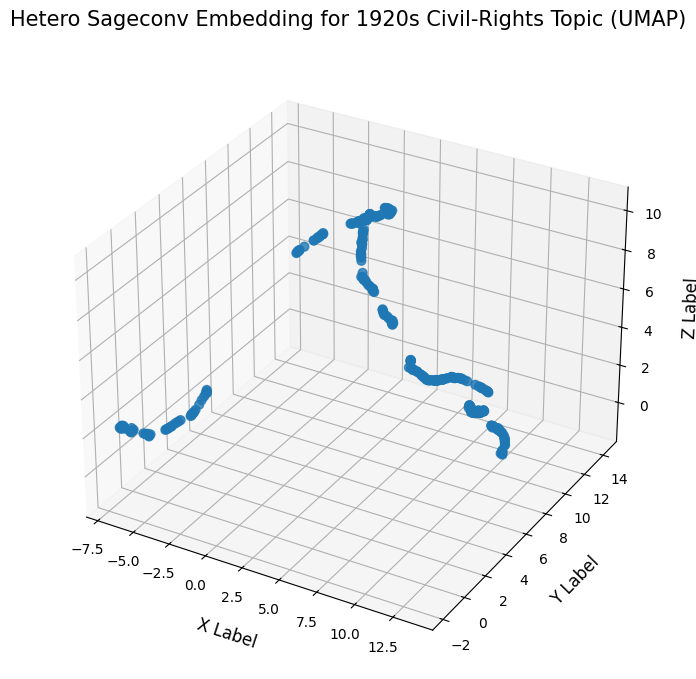

Graph saved at: Writeup/civil-rights_20_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_umap.png


In [42]:
create_embedding_plot(topic='civil-rights',
                      decade=20,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='umap',
                      use_colors=False)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


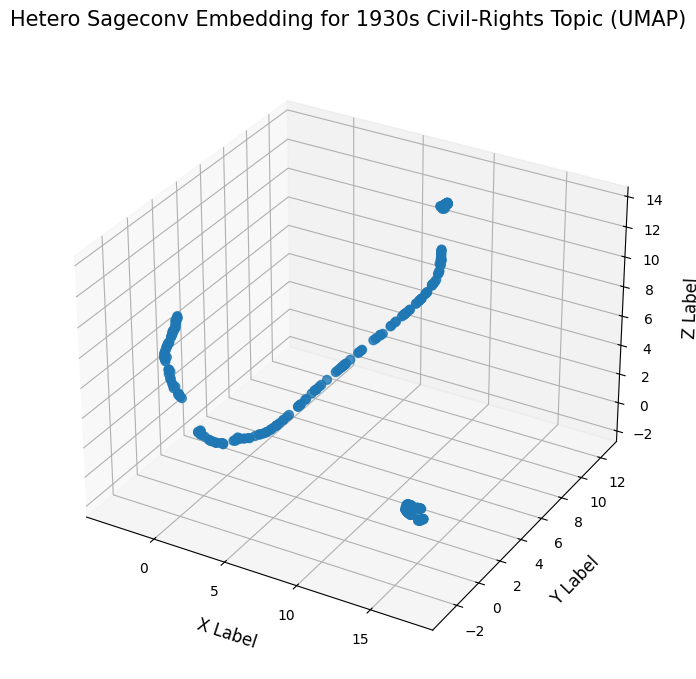

Graph saved at: Writeup/civil-rights_30_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_umap.png


In [43]:
create_embedding_plot(topic='civil-rights',
                      decade=30,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='umap',
                      use_colors=False)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


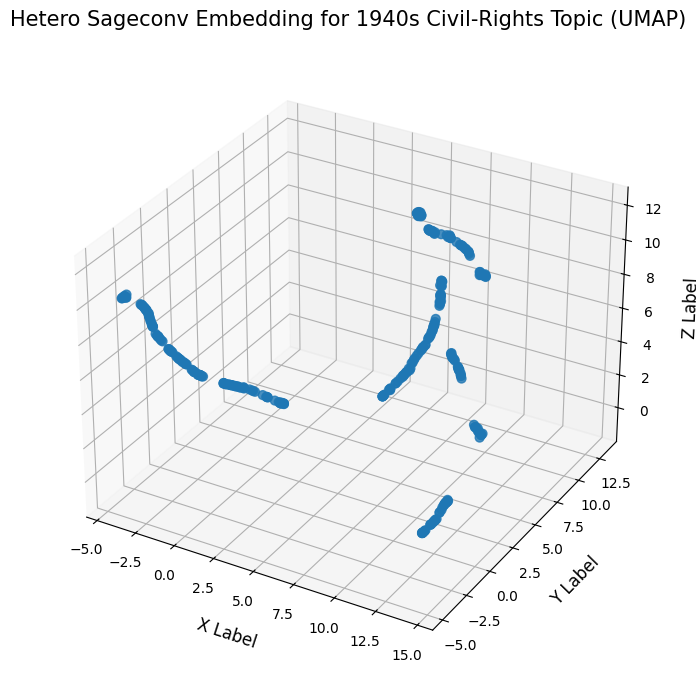

Graph saved at: Writeup/civil-rights_40_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_umap.png


In [44]:
create_embedding_plot(topic='civil-rights',
                      decade=40,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='umap',
                      use_colors=False)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


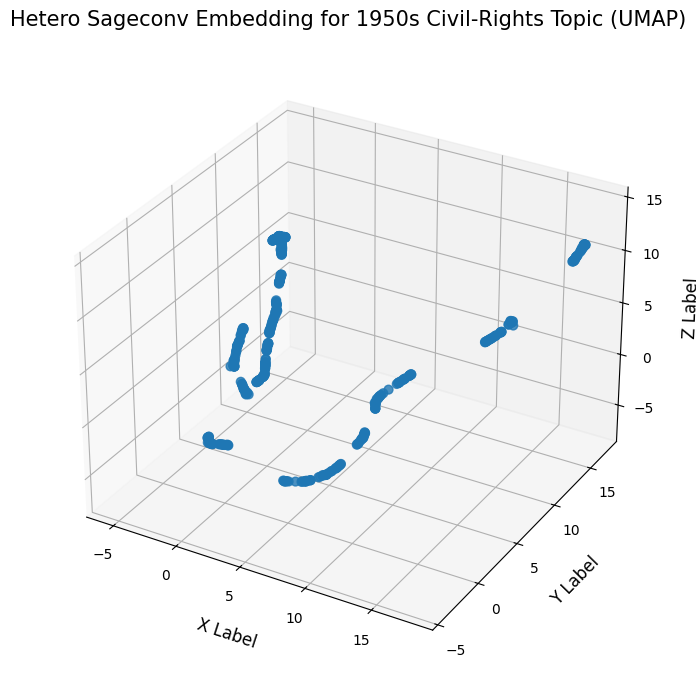

Graph saved at: Writeup/civil-rights_50_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_umap.png


In [45]:

create_embedding_plot(topic='civil-rights',
                      decade=50,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='umap',
                      use_colors=False)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


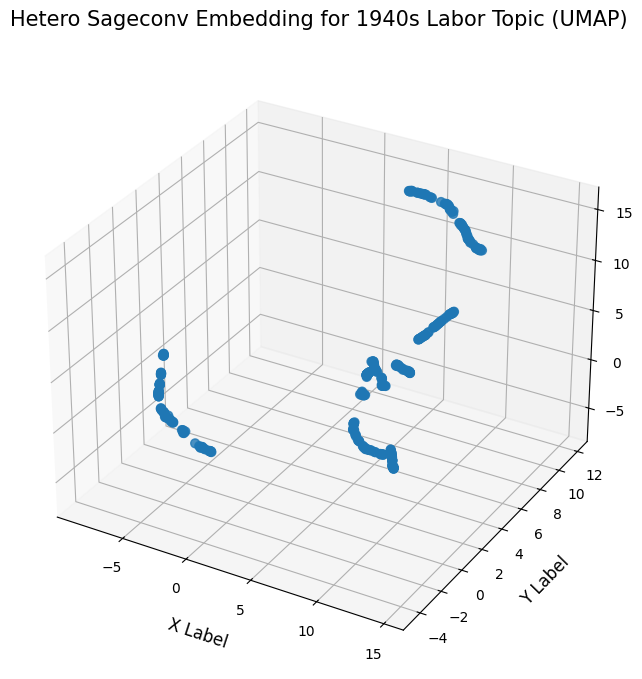

Graph saved at: Writeup/labor_40_het_sage_t0.08_a10_h128_o128_l1_lr5.0_hetero_umap.png


In [46]:
#Do we see the same behavior for labor ?

create_embedding_plot(topic='labor',
                      decade=40,
                      model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
                      model_name="Hetero SageConv",
                      graph_type='hetero',
                      reduction_method='umap',
                      use_colors=False)

#Clustering Civil Rights Topic Across Decades

Now we look at clustering results across decades for the Civil Rights topic

In [44]:
results_20, _, _, full_cluster_df20 = clustering_metrics(
    topic='civil-rights',
    decade=20,
    model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
    model_name="Hetero SageConv",
    graph_type='hetero',
    labels=False
)

In [45]:
results_20

{'mean_radius': 5.4154315,
 'max_radius': 15.13265,
 'num_clusters': 4,
 'num_outliers': 6,
 'min_cluster_size': 18,
 'max_cluster_size': 130,
 'avg_cluster_size': 82.75}

In [32]:
results_30, _, _, full_cluster_df30 = clustering_metrics(
    topic='civil-rights',
    decade=30,
    model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
    model_name="Hetero SageConv",
    graph_type='hetero',
    labels=False
)

In [33]:
results_30

{'mean_radius': 7.578412,
 'max_radius': 30.072668,
 'num_clusters': 3,
 'num_outliers': 10,
 'min_cluster_size': 75,
 'max_cluster_size': 141,
 'avg_cluster_size': 108.0}

In [34]:
results_40, _, _, full_cluster_df40 = clustering_metrics(
    topic='civil-rights',
    decade=40,
    model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
    model_name="Hetero SageConv",
    graph_type='hetero',
    labels=False
)

In [35]:
results_40

{'mean_radius': 7.022432,
 'max_radius': 25.156042,
 'num_clusters': 2,
 'num_outliers': 0,
 'min_cluster_size': 83,
 'max_cluster_size': 285,
 'avg_cluster_size': 184.0}

In [36]:
results_50, _, _, full_cluster_df50 = clustering_metrics(
    topic='civil-rights',
    decade=50,
    model='het_sage_t0.08_a10_h128_o128_l1_lr5.0',
    model_name="Hetero SageConv",
    graph_type='hetero',
    labels=False
)

In [37]:
results_50

{'mean_radius': 6.0292625,
 'max_radius': 21.901834,
 'num_clusters': 2,
 'num_outliers': 2,
 'min_cluster_size': 60,
 'max_cluster_size': 423,
 'avg_cluster_size': 241.5}

# Cluster Raw Node Features

In [55]:
def get_baseline_info(topic, decade):
    """
    Retrieves and preprocesses raw node features and their corresponding labels.

    Parameters:
    - topic (str): Topic of interest (e.g., 'labor', 'economics').
    - decade (int): Decade of interest (e.g., 60, 70, 80).

    Returns:
    - X (ndarray): Scaled feature matrix for the nodes.
    - y (Series): Labels for the nodes (0 for Republican, 1 for Democrat).
    """
    # Clean outlet metadata
    outlet_metadata_df = pd.read_pickle(f"karsen_redo/DATA/outlet_metadata_{decade}{decade+10}_{topic}.pkl")
    outlet_metadata_df[['latitude', 'longitude']] = pd.DataFrame(outlet_metadata_df['newspaper_coordinates'].tolist())
    outlet_metadata_df = outlet_metadata_df.drop(columns=['newspaper_coordinates'])
    # Convert list of embeddings into a bunch of columns
    outlet_metadata_df = outlet_metadata_df.drop(columns=['avg_embedding', 'newspaper_city', 'newspaper_state'])

    # Find ground truths
    ground_truths = pd.read_pickle(f"karsen_redo/DATA/clean_ground_truths.pkl")

    merged = pd.merge(outlet_metadata_df, ground_truths, on='outlet_name').dropna() # Drop if no ground truth available
    X = merged.drop(columns=['label', 'outlet_name'])
    y = merged['label']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

def plot_dimension_reduced_raw_features(topic, decade, reduction_method='TSNE', use_colors=True):
    """
    Performs dimensionality reduction on raw node features and plots a 3D scatter plot.

    Parameters:
    - topic (str): Topic of interest (e.g., 'labor', 'economics').
    - decade (int): Decade of interest (e.g., 60, 70, 80).
    - reduction_method (str): Dimensionality reduction method ('TSNE', 'PCA', 'UMAP'). Default is 'TSNE'.
    - use_colors (bool): Whether to color points based on their labels (True for color coding, False for default).

    Saves:
    - A 3D scatter plot of the dimension-reduced node features, color-coded by labels, to a file.
    """

    # Helper function for dimensionality reduction
    def reduce_dimensions(X, method, **kwargs):
        if method.upper() == 'TSNE':
            return TSNE(n_components=3, random_state=42, **kwargs).fit_transform(X)
        elif method.upper() == 'PCA':
            return PCA(n_components=3, random_state=42).fit_transform(X)
        elif method.upper() == 'UMAP':
            return umap.UMAP(n_components=3, random_state=42, **kwargs).fit_transform(X)
        else:
            raise ValueError(f"Unsupported reduction method: {method}. Choose from 'PCA', 'TSNE', or 'UMAP'.")

    # Retrieve raw features and labels
    X, y = get_baseline_info(topic, decade)

    # Define parameters for dimensionality reduction
    reduction_params = {}
    if reduction_method.upper() == 'TSNE':
        reduction_params['perplexity'] = int(X.shape[0] * 0.05)  # Set perplexity to around 5% of dataset

    # Perform dimensionality reduction
    X_embedded = reduce_dimensions(X, reduction_method, **reduction_params)

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    if use_colors:
        # Assign colors based on labels (0 -> Red, 1 -> Blue)
        colors_list = ['red' if label == 0 else 'blue' for label in y]
        scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=colors_list, s=40, alpha=0.8)

        # Add a legend
        legend_labels = ['Republican (Red)', 'Democrat (Blue)']
        legend_colors = ['red', 'blue']
        for label, color in zip(legend_labels, legend_colors):
            ax.scatter([], [], c=color, label=label)  # Dummy scatter points for legend
        ax.legend(loc='upper right', fontsize=10)
    else:
        scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], s=40, alpha=0.8)

    # Set axis labels and title
    ax.set_xlabel('X Label', fontsize=12, labelpad=10)
    ax.set_ylabel('Y Label', fontsize=12, labelpad=10)
    ax.set_zlabel('Z Label', fontsize=12, labelpad=10)
    ax.set_title(f"Raw Node Features for 19{decade}s {topic.title()} ({reduction_method.upper()})", fontsize=15, pad=20)

    # Save the plot
    output_folder = 'Writeup/'
    os.makedirs(output_folder, exist_ok=True)  # Create directory if it doesn't exist
    file_path = os.path.join(output_folder, f'{topic}_{decade}_raw_features_{reduction_method.lower()}.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

    print(f'Graph saved at: {file_path}')


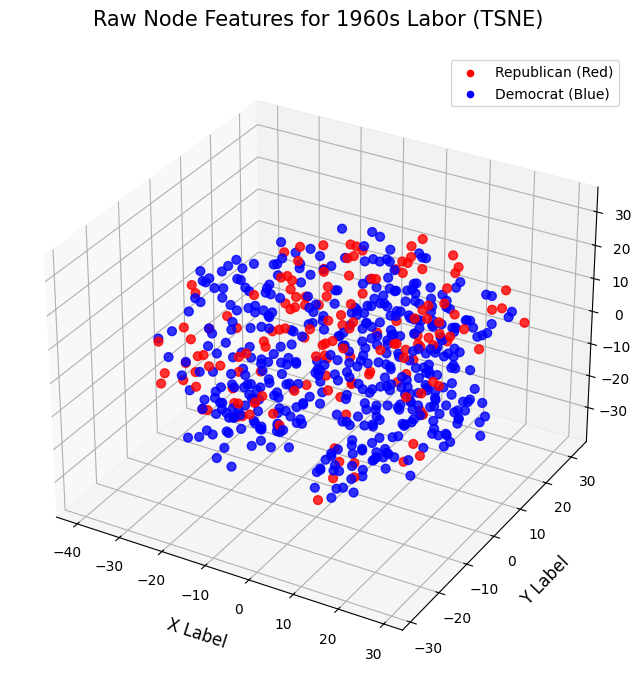

Graph saved at: Writeup/labor_60_raw_features_tsne.png


In [56]:
plot_dimension_reduced_raw_features('labor', 60)

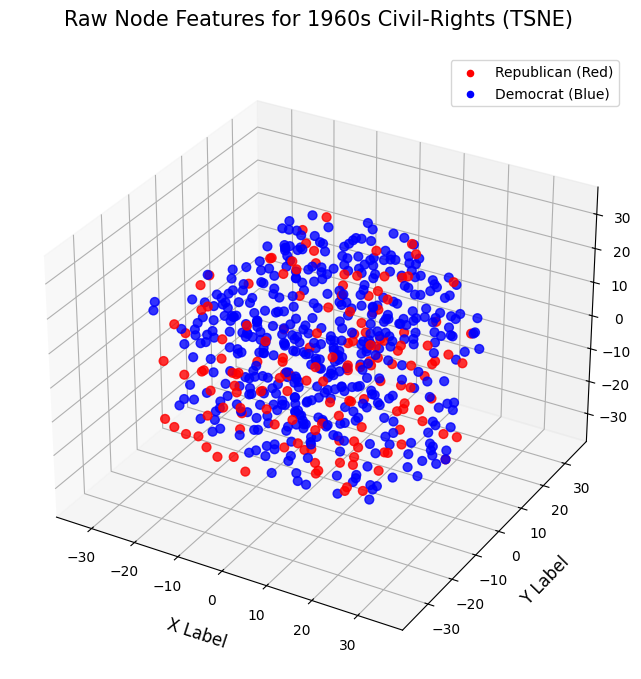

Graph saved at: Writeup/civil-rights_60_raw_features_tsne.png


In [57]:
plot_dimension_reduced_raw_features('civil-rights', 60)

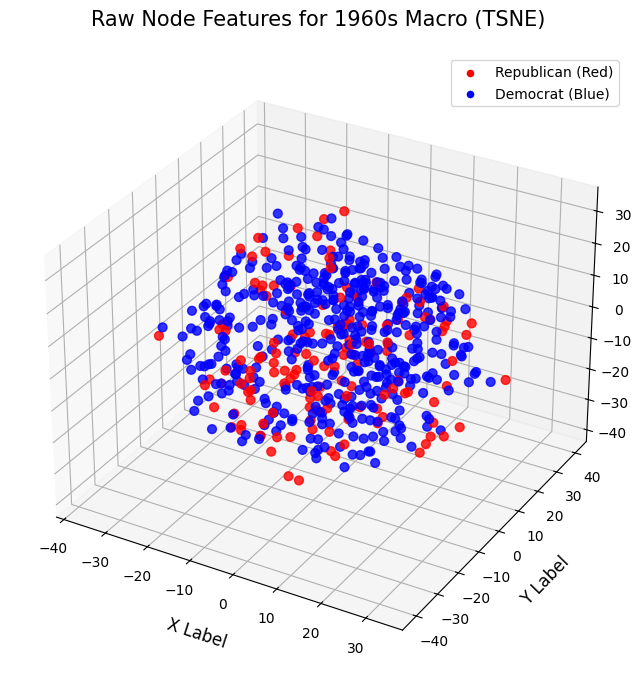

Graph saved at: Writeup/macro_60_raw_features_tsne.png


In [58]:
plot_dimension_reduced_raw_features('macro', 60)